# Import Library

In [1]:
# Import Library
import numpy as np
import pandas as pd
import tensorflow as tf
import kerastuner as kt
import joblib
from collections import Counter

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
from tensorflow.keras import layers
from gensim.models import FastText, KeyedVectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch,Objective

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize

# Model Performance
import seaborn as sns
import matplotlib.pyplot as plt


C:\Users\Asus\AppData\Local\Temp\ipykernel_17328\1542969705.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# Data Preparation

## Balancing all label before data preparation

In [ ]:
file_path_emotion = r"../Pre_Hate_Dataset/20_Hate_Final.csv"
df_emotion = pd.read_csv(file_path_emotion)

emo_texts = df_emotion['text'].astype(str).values
emo_labels = df_emotion['label'].values

label_encoder_emotion = LabelEncoder()
emo_labels_encoded = label_encoder_emotion.fit_transform(emo_labels)

rus = RandomUnderSampler(random_state=42)
emo_texts_resampled, emo_labels_resampled = rus.fit_resample(emo_texts.reshape(-1, 1), emo_labels_encoded)

emo_texts_resampled = emo_texts_resampled.flatten()

emo_labels_resampled = label_encoder_emotion.inverse_transform(emo_labels_resampled)

df_resampled = pd.DataFrame({'text': emo_texts_resampled, 'label': emo_labels_resampled})

new_file_path = r"../Pre_Hate_Dataset/20_Hate_Final_Undersampled.csv"
df_resampled.to_csv(new_file_path, index=False)

print(f"Undersampled data saved to {new_file_path}")


Undersampled data saved to ../Pre_Hate_Dataset/20_Hate_Final_Undersampled.csv


## 1 - balance test set

In [ ]:
MAX_VOCAB_SIZE = 20000  
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300 

file_path_hate = r"../Pre_Hate_Dataset/20_Hate_Final.csv"
file_path_emotion = r"../Pre_Emotion_Dataset/8_Lemmatization.csv"
df_hate = pd.read_csv(file_path_hate)
df_emotion = pd.read_csv(file_path_emotion)

hate_texts = df_hate['text'].astype(str).values
hate_labels = df_hate['label'].values
emo_texts = df_emotion['text'].astype(str).values
emo_labels = df_emotion['label'].values

# Encode labels
label_encoder_hate = LabelEncoder()
hate_labels = label_encoder_hate.fit_transform(hate_labels)

label_encoder_emotion = LabelEncoder()
emo_labels = label_encoder_emotion.fit_transform(emo_labels)

# Train-test split
hate_texts_train, hate_texts_test, hate_labels_train, hate_labels_test = train_test_split(
    hate_texts, hate_labels, test_size=0.3, stratify=hate_labels, random_state=42
)

emo_texts_train, emo_texts_test, emo_labels_train, emo_labels_test = train_test_split(
    emo_texts, emo_labels, test_size=0.3, stratify=emo_labels, random_state=42
)

# Tokenization (Fit only on training data)
tokenizer_hate = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_hate.fit_on_texts(hate_texts_train)

tokenizer_emo = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_emo.fit_on_texts(emo_texts_train)

# Convert texts to sequences
hate_seq_train = tokenizer_hate.texts_to_sequences(hate_texts_train)
hate_seq_test = tokenizer_hate.texts_to_sequences(hate_texts_test)

emo_seq_train = tokenizer_emo.texts_to_sequences(emo_texts_train)
emo_seq_test = tokenizer_emo.texts_to_sequences(emo_texts_test)

# Padding
hate_padding_train = pad_sequences(hate_seq_train, maxlen=MAX_SEQUENCE_LENGTH)
hate_padding_test = pad_sequences(hate_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

emo_padding_train = pad_sequences(emo_seq_train, maxlen=MAX_SEQUENCE_LENGTH)
emo_padding_test = pad_sequences(emo_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

X_train_hate, X_test_hate, Y_train_hate, Y_test_hate = hate_padding_train, hate_padding_test, hate_labels_train, hate_labels_test
X_train_emo, X_test_emo, Y_train_emo, Y_test_emo = emo_padding_train, emo_padding_test, emo_labels_train, emo_labels_test

# Undersampling -----------------------------------------------------------------------------------------------------------------------------

# Train Set
undersampler_hate_train = RandomUnderSampler(random_state=42,sampling_strategy={0: 18063, 1: 18063}) 
undersampler_emo_train = RandomUnderSampler(random_state=42,sampling_strategy={0: 12042, 1: 12042, 2: 12042}) 

# Test Set
undersampler_hate_test = RandomUnderSampler(random_state=42,sampling_strategy={0: 7740, 1: 7740}) 
undersampler_emo_test = RandomUnderSampler(random_state=42,sampling_strategy={0: 5160, 1: 5160, 2: 5160}) 

X_train_hate_resampled, Y_train_hate_resampled = undersampler_hate_train.fit_resample(X_train_hate, Y_train_hate)
X_train_emo_resampled, Y_train_emo_resampled = undersampler_emo_train.fit_resample(X_train_emo, Y_train_emo)

X_test_hate_resample, Y_test_hate_resample = undersampler_hate_test.fit_resample(X_test_hate, Y_test_hate)
X_test_emo_resample, Y_test_emo_resample= undersampler_emo_test.fit_resample(X_test_emo, Y_test_emo)

# Confirm whether the label of the dataset corresponds correctly to the text data
# print("Hate test resample check:", np.array_equal(Y_test_hate_resample, Y_test_hate[indices_hate]))
# print("Emotion test resample check:", np.array_equal(Y_test_emo_resample, Y_test_emo[indices_emo]))

print("\n📌 Before Resampling --------------------------------------------------------------------------------------")
print("\nHate Train-test Split:")
print("X_train_hate shape", X_train_hate.shape)
print("Y_train_hate shape", Y_train_hate.shape)
print("X_test_hate shape", X_test_hate.shape)
print("Y_test_hate shape", Y_test_hate.shape)

train_label_counts = Counter(Y_train_hate)
test_label_counts = Counter(Y_test_hate)
print("\nTraining label distribution:", train_label_counts)
print("Testing label distribution:", test_label_counts)

print("\nEmotion Train-test Split:", )
print("X_train_emo shape", X_train_emo.shape)
print("Y_train_emo shape", Y_train_emo.shape)
print("X_test_emo shape", X_test_emo.shape)
print("Y_test_emo shape", Y_test_emo.shape)

train_label_counts = Counter(Y_train_emo)
test_label_counts = Counter(Y_test_emo)
print("\nTraining label distribution:", train_label_counts)
print("Testing label distribution:", test_label_counts)

print("\n📌 After Resampling --------------------------------------------------------------------------------------")

print("\nHate Train-test Split:")
print("X_train_hate shape", X_train_hate_resampled.shape)
print("Y_train_hate shape", Y_train_hate_resampled.shape)
print("X_test_hate shape", X_test_hate_resample.shape)
print("Y_test_hate shape", Y_test_hate_resample.shape)

train_label_counts = Counter(Y_train_hate_resampled)
test_label_counts = Counter(Y_test_hate_resample)
print("\nTraining label distribution:", train_label_counts)
print("Testing label distribution:", test_label_counts)

print("\nEmotion Train-test Split:", )
print("X_train_emo shape", X_train_emo_resampled.shape)
print("Y_train_emo shape", Y_train_emo_resampled.shape)
print("X_test_emo shape", X_test_emo_resample.shape)
print("Y_test_emo shape", Y_test_emo_resample.shape)

train_label_counts = Counter(Y_train_emo_resampled)
test_label_counts = Counter(Y_test_emo_resample)
print("\nTraining label distribution:", train_label_counts)
print("Testing label distribution:", test_label_counts)


📌 Before Resampling --------------------------------------------------------------------------------------

Hate Train-test Split:
X_train_hate shape (57447, 100)
Y_train_hate shape (57447,)
X_test_hate shape (24621, 100)
Y_test_hate shape (24621,)

Training label distribution: Counter({0: 39384, 1: 18063})
Testing label distribution: Counter({0: 16880, 1: 7741})

Emotion Train-test Split:
X_train_emo shape (171966, 100)
Y_train_emo shape (171966,)
X_test_emo shape (73700, 100)
Y_test_emo shape (73700,)

Training label distribution: Counter({0: 98543, 1: 40060, 2: 33363})
Testing label distribution: Counter({0: 42233, 1: 17169, 2: 14298})

📌 After Resampling --------------------------------------------------------------------------------------

Hate Train-test Split:
X_train_hate shape (36126, 100)
Y_train_hate shape (36126,)
X_test_hate shape (15480, 100)
Y_test_hate shape (15480,)

Training label distribution: Counter({0: 18063, 1: 18063})
Testing label distribution: Counter({0: 774

## 2 - none balance test set

In [2]:
MAX_VOCAB_SIZE = 20000  
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300 

file_path_hate = r"../Pre_Hate_Dataset/20_Hate_Final.csv"
file_path_emotion = r"../Pre_Emotion_Dataset/8_Lemmatization.csv"
df_hate = pd.read_csv(file_path_hate)
df_emotion = pd.read_csv(file_path_emotion)

hate_texts = df_hate['text'].astype(str).values
hate_labels = df_hate['label'].values
emo_texts = df_emotion['text'].astype(str).values
emo_labels = df_emotion['label'].values

# Encode labels
label_encoder_hate = LabelEncoder()
hate_labels = label_encoder_hate.fit_transform(hate_labels)

label_encoder_emotion = LabelEncoder()
emo_labels = label_encoder_emotion.fit_transform(emo_labels)

# Train-test split
hate_texts_train, hate_texts_test, hate_labels_train, hate_labels_test = train_test_split(
    hate_texts, hate_labels, test_size=0.3, stratify=hate_labels, random_state=42
)

emo_texts_train, emo_texts_test, emo_labels_train, emo_labels_test = train_test_split(
    emo_texts, emo_labels, test_size=0.3, stratify=emo_labels, random_state=42
)

# Tokenization (Fit only on training data)
tokenizer_hate = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_hate.fit_on_texts(hate_texts_train)

tokenizer_emo = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_emo.fit_on_texts(emo_texts_train)

# Convert texts to sequences
hate_seq_train = tokenizer_hate.texts_to_sequences(hate_texts_train)
hate_seq_test = tokenizer_hate.texts_to_sequences(hate_texts_test)

emo_seq_train = tokenizer_emo.texts_to_sequences(emo_texts_train)
emo_seq_test = tokenizer_emo.texts_to_sequences(emo_texts_test)

# Padding
hate_padding_train = pad_sequences(hate_seq_train, maxlen=MAX_SEQUENCE_LENGTH)
hate_padding_test = pad_sequences(hate_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

emo_padding_train = pad_sequences(emo_seq_train, maxlen=MAX_SEQUENCE_LENGTH)
emo_padding_test = pad_sequences(emo_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

X_train_hate, X_test_hate, Y_train_hate, Y_test_hate = hate_padding_train, hate_padding_test, hate_labels_train, hate_labels_test
X_train_emo, X_test_emo, Y_train_emo, Y_test_emo = emo_padding_train, emo_padding_test, emo_labels_train, emo_labels_test

# Undersampling -----------------------------------------------------------------------------------------------------------------------------

# Train Set
undersampler_hate_train = RandomUnderSampler(random_state=42,sampling_strategy={0: 18063, 1: 18063}) 
undersampler_emo_train = RandomUnderSampler(random_state=42,sampling_strategy={0: 12042, 1: 12042, 2: 12042}) 
X_train_hate_resampled, Y_train_hate_resampled = undersampler_hate_train.fit_resample(X_train_hate, Y_train_hate)
X_train_emo_resampled, Y_train_emo_resampled = undersampler_emo_train.fit_resample(X_train_emo, Y_train_emo)

# Validation Set
rng = np.random.RandomState(42)
min_test_size = min(len(X_test_hate), len(X_test_emo))  # Find min distribution in both datasets

# Hate Validation set
# replace=False: Indicates that the same sample cannot be selected repeatedly during sampling
indices_hate = rng.choice(len(X_test_hate), min_test_size, replace=False)
X_test_hate_resample = X_test_hate[indices_hate]
Y_test_hate_resample = Y_test_hate[indices_hate]

# Emotion Validation set
indices_emo = rng.choice(len(X_test_emo), min_test_size, replace=False)
X_test_emo_resample = X_test_emo[indices_emo]
Y_test_emo_resample = Y_test_emo[indices_emo]

# Confirm whether the label of the dataset corresponds correctly to the text data
print("Hate Validation resample check:", np.array_equal(Y_test_hate_resample, Y_test_hate[indices_hate]))
print("Emotion Validation resample check:", np.array_equal(Y_test_emo_resample, Y_test_emo[indices_emo]))

print("\n📌 Before Resampling --------------------------------------------------------------------------------------")
print("\nHate Train-test Split:")
print("X_train_hate shape", X_train_hate.shape)
print("Y_train_hate shape", Y_train_hate.shape)
print("X_test_hate shape", X_test_hate.shape)
print("Y_test_hate shape", Y_test_hate.shape)

train_label_counts = Counter(Y_train_hate)
test_label_counts = Counter(Y_test_hate)
print("\nTraining label distribution:", train_label_counts)
print("Validation label distribution:", test_label_counts)

print("\nEmotion Train-test Split:", )
print("X_train_emo shape", X_train_emo.shape)
print("Y_train_emo shape", Y_train_emo.shape)
print("X_test_emo shape", X_test_emo.shape)
print("Y_test_emo shape", Y_test_emo.shape)

train_label_counts = Counter(Y_train_emo)
test_label_counts = Counter(Y_test_emo)
print("\nTraining label distribution:", train_label_counts)
print("Validation label distribution:", test_label_counts)

print("\n📌 After Resampling --------------------------------------------------------------------------------------")

print("\nHate Train-test Split:")
print("X_train_hate shape", X_train_hate_resampled.shape)
print("Y_train_hate shape", Y_train_hate_resampled.shape)
print("X_test_hate shape", X_test_hate_resample.shape)
print("Y_test_hate shape", Y_test_hate_resample.shape)

train_label_counts = Counter(Y_train_hate_resampled)
test_label_counts = Counter(Y_test_hate_resample)
print("\nTraining label distribution:", train_label_counts)
print("Validation label distribution:", test_label_counts)

print("\nEmotion Train-test Split:", )
print("X_train_emo shape", X_train_emo_resampled.shape)
print("Y_train_emo shape", Y_train_emo_resampled.shape)
print("X_test_emo shape", X_test_emo_resample.shape)
print("Y_test_emo shape", Y_test_emo_resample.shape)

train_label_counts = Counter(Y_train_emo_resampled)
test_label_counts = Counter(Y_test_emo_resample)
print("\nTraining label distribution:", train_label_counts)
print("Validation label distribution:", test_label_counts)

Hate Validation resample check: True
Emotion Validation resample check: True

📌 Before Resampling --------------------------------------------------------------------------------------

Hate Train-test Split:
X_train_hate shape (57447, 100)
Y_train_hate shape (57447,)
X_test_hate shape (24621, 100)
Y_test_hate shape (24621,)

Training label distribution: Counter({0: 39384, 1: 18063})
Validation label distribution: Counter({0: 16880, 1: 7741})

Emotion Train-test Split:
X_train_emo shape (171966, 100)
Y_train_emo shape (171966,)
X_test_emo shape (73700, 100)
Y_test_emo shape (73700,)

Training label distribution: Counter({0: 98543, 1: 40060, 2: 33363})
Validation label distribution: Counter({0: 42233, 1: 17169, 2: 14298})

📌 After Resampling --------------------------------------------------------------------------------------

Hate Train-test Split:
X_train_hate shape (36126, 100)
Y_train_hate shape (36126,)
X_test_hate shape (24621, 100)
Y_test_hate shape (24621,)

Training label dist

# 1. Imbalance Validation Set Model - MTL (2 input , 2 output) , saved model name: MTL_Model_1_imbalanceTestSet

## Word Embedding

In [ ]:
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300 
MAX_VOCAB_SIZE_HATE = len(tokenizer_hate.word_index) + 1
MAX_VOCAB_SIZE_EMO = len(tokenizer_emo.word_index) + 1

hate_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="hate_input")
emo_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="emo_input")

# FastText
fasttext_path = "crawl-300d-2M-subword.bin" 
fasttext_vectors = FastText.load_fasttext_format(fasttext_path)

embedding_matrix_fastText = np.zeros((MAX_VOCAB_SIZE_HATE, EMBEDDING_DIM))
for word, i in tokenizer_hate.word_index.items():
    if i < MAX_VOCAB_SIZE_HATE:
        if word in fasttext_vectors.wv:
            embedding_matrix_fastText[i] = fasttext_vectors.wv[word]
        else:
            embedding_matrix_fastText[i] = np.random.normal(size=(EMBEDDING_DIM,))   

# Word2Vec
word2vec_path = "GoogleNews-vectors-negative300.bin"
word2vec_vectors = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

embedding_matrix_word2Vec = np.zeros((MAX_VOCAB_SIZE_EMO, EMBEDDING_DIM))
for word, i in tokenizer_emo.word_index.items():
    if i < MAX_VOCAB_SIZE_EMO:
        if word in word2vec_vectors:
            embedding_matrix_word2Vec[i] = word2vec_vectors[word]
        else:
            embedding_matrix_word2Vec[i] = np.random.normal(size=(EMBEDDING_DIM,))

hate_embedding = Embedding(
    input_dim=MAX_VOCAB_SIZE_HATE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix_fastText],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True
)(hate_input)

emo_embedding = Embedding(
    input_dim=MAX_VOCAB_SIZE_EMO,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix_word2Vec],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True
)(emo_input)



C:\Users\Asus\AppData\Local\Temp\ipykernel_27216\806625707.py:12: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_vectors = FastText.load_fasttext_format(fasttext_path)
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Model

In [4]:
# hate speech Bi-LSTM
hate_lstm_1 = Bidirectional(LSTM(64, return_sequences=True))(hate_embedding)
hate_dropout_1 = Dropout(0.4)(hate_lstm_1)

hate_lstm_2 = Bidirectional(LSTM(96, return_sequences=True))(hate_dropout_1)
hate_dropout_2 = Dropout(0.4)(hate_lstm_2)

hate_lstm_3 = Bidirectional(LSTM(48, return_sequences=False))(hate_dropout_2)
hate_dropout_3 = Dropout(0.2)(hate_lstm_3)

# emotion Bi-LSTM
emo_lstm_1 = Bidirectional(LSTM(64, return_sequences=True))(emo_embedding)
emo_dropout_1 = Dropout(0.4)(emo_lstm_1)

emo_lstm_2 = Bidirectional(LSTM(96, return_sequences=True))(emo_dropout_1)
emo_dropout_2 = Dropout(0.4)(emo_lstm_2)

emo_lstm_3 = Bidirectional(LSTM(48, return_sequences=False))(emo_dropout_2)
emo_dropout_3 = Dropout(0.2)(emo_lstm_3)

# combined features
combined_features = concatenate([hate_dropout_3, emo_dropout_3])
shared_dense = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.071))(combined_features)

# output layer
hate_output = Dense(1, activation='sigmoid', name="hate_output")(shared_dense)
emotion_output = Dense(3, activation='softmax', name="emotion_output")(shared_dense)
model = Model(inputs=[hate_input, emo_input], outputs=[hate_output, emotion_output])

model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss={  "hate_output": "binary_crossentropy",  "emotion_output": "sparse_categorical_crossentropy" },
    metrics={ "hate_output": "accuracy", "emotion_output": "accuracy" }
)

early_stopping = EarlyStopping(monitor='val_hate_output_loss', mode='min',patience=3, restore_best_weights=True)

history = model.fit(
    x={  
        "hate_input": X_train_hate_resampled,
        "emo_input":X_train_emo_resampled},
    y={
        "hate_output": Y_train_hate_resampled,
        "emotion_output": Y_train_emo_resampled
    },
    epochs=10,
    batch_size=32,
    validation_data=(
        {
            "hate_input": X_test_hate_resample,
            "emo_input": X_test_emo_resample
        },
        {
            "hate_output": Y_test_hate_resample,
            "emotion_output": Y_test_emo_resample
        }
    ),
    callbacks=[early_stopping],
    verbose=1
)

# Save model-----------------------------------------------------------------------------------

model.save("MTL_Model_1_imbalanceTestSet.h5")
joblib.dump(history.history, "MTL_History_1_imbalanceTestSet.pkl")
print("Model saved successfully!")


Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 603s 521ms/step - emotion_output_accuracy: 0.8776 - emotion_output_loss: 0.3065 - hate_output_accuracy: 0.8474 - hate_output_loss: 0.3137 - loss: 0.9541 - val_emotion_output_accuracy: 0.9737 - val_emotion_output_loss: 0.0837 - val_hate_output_accuracy: 0.6383 - val_hate_output_loss: 1.3308 - val_loss: 1.4547
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 491s 435ms/step - emotion_output_accuracy: 0.9784 - emotion_output_loss: 0.0613 - hate_output_accuracy: 0.9329 - hate_output_loss: 0.1568 - loss: 0.2578 - val_emotion_output_accuracy: 0.9751 - val_emotion_output_loss: 0.0894 - val_hate_output_accuracy: 0.6408 - val_hate_output_loss: 1.4257 - val_loss: 1.5572
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 479s 425ms/step - emotion_output_accuracy: 0.9827 - emotion_output_loss: 0.0490 - hate_output_accuracy: 0.9514 - hate_output_loss: 0.1216 - loss: 0.2043 - val_emotion_output_accuracy: 0.9696 - val_emotion_output_loss: 0.1011 - val_hate_output_accuracy: 0

Model saved successfully!


## Evaluate

In [ ]:
# Validation Accurancy
results_Test = model.evaluate(
    {"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample}, 
    {"hate_output": Y_test_hate_resample, "emotion_output": Y_test_emo_resample}, 
    verbose=1,
    return_dict=True
)
print("\nEvaluation Results: (test)")
print("="*30)
print(f"Total Loss: {results_Test['loss']:.4f}")
print("-"*30)
print(f"Hate Loss: {results_Test['hate_output_loss']:.4f}")
print(f"Emotion Loss: {results_Test['emotion_output_loss']:.4f}")
print("-"*30)
print(f"Hate Accuracy: {results_Test['hate_output_accuracy']*100:.2f}%")
print(f"Emotion Accuracy: {results_Test['emotion_output_accuracy']*100:.2f}%")
print("="*30)


770/770 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - emotion_output_accuracy: 0.9744 - emotion_output_loss: 0.0835 - hate_output_accuracy: 0.6369 - hate_output_loss: 1.3518 - loss: 1.4754

Evaluation Results:
Total Loss: 1.4547
------------------------------
Hate Loss: 1.3308
Emotion Loss: 0.0837
------------------------------
Hate Accuracy: 63.83%
Emotion Accuracy: 97.37%


In [24]:
# Train Accurancy
result_train = model.evaluate(
    {"hate_input": X_train_hate_resampled, "emo_input": X_train_emo_resampled}, 
    {"hate_output": Y_train_hate_resampled, "emotion_output": Y_train_emo_resampled}, 
    verbose=1,return_dict=True
)
print("\nEvaluation Results: (test)")
print("="*30)
print(f"Total Loss: {result_train['loss']:.4f}")
print("-"*30)
print(f"Hate Loss: {result_train['hate_output_loss']:.4f}")
print(f"Emotion Loss: {result_train['emotion_output_loss']:.4f}")
print("-"*30)
print(f"Hate Accuracy: {result_train['hate_output_accuracy']*100:.2f}%")
print(f"Emotion Accuracy: {result_train['emotion_output_accuracy']*100:.2f}%")
print("="*30)

1129/1129 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - emotion_output_accuracy: 0.9839 - emotion_output_loss: 0.0433 - hate_output_accuracy: 0.9549 - hate_output_loss: 0.1089 - loss: 0.1923

Evaluation Results: (test)
Total Loss: 0.2499
------------------------------
Hate Loss: 0.1481
Emotion Loss: 0.0618
------------------------------
Hate Accuracy: 94.15%
Emotion Accuracy: 97.67%


In [27]:
y_pred = model.predict({"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample})

y_pred_hate = y_pred[0]  
y_pred_emo = y_pred[1]  

y_pred_hate_class = (y_pred_hate > 0.5).astype(int)
y_pred_emo_class = np.argmax(y_pred_emo, axis=1)

print(f"\n-------------------------------😈 Hate 😈-------------------------------")

f1_weighted = f1_score(Y_test_hate_resample, y_pred_hate_class, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test_hate_resample, y_pred_hate_class, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test_hate_resample, y_pred_hate_class, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test_hate_resample, y_pred_hate_class, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test_hate_resample, y_pred_hate_class, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr_hate, tpr_hate, _ = roc_curve(Y_test_hate_resample, y_pred_hate)
roc_auc_hate = auc(fpr_hate, tpr_hate)
print(f"\n📌Test ROC AUC: {roc_auc_hate:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test_hate_resample, y_pred_hate_class))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test_hate_resample, y_pred_hate_class))

print(f"\n-------------------------------😈 Emotion 😈-------------------------------")

f1_weighted = f1_score(Y_test_emo_resample, y_pred_emo_class, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test_emo_resample, y_pred_emo_class, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test_emo_resample, y_pred_emo_class, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

Y_test_emo_bin = label_binarize(Y_test_emo_resample, classes=np.unique(Y_test_emo_resample))

n_classes = Y_test_emo_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_emo_bin[:, i], y_pred_emo[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Print ROC AUC for each class
for i in range(n_classes):
    print(f"📌Test ROC AUC for class {i}: {roc_auc[i]:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test_emo_resample, y_pred_emo_class))

print("Confusion Matrix:")
print(confusion_matrix(Y_test_emo_resample, y_pred_emo_class))


770/770 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step

-------------------------------😈 Hate 😈-------------------------------

📌 Weighted F1 Score: 0.6353
📌 Micro F1 Score: 0.6383
📌 Macro F1 Score: 0.5737

📌 Precision: 0.4202
📌 Recall: 0.3961

📌Test ROC AUC: 0.6595

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     16880
           1       0.42      0.40      0.41      7741

    accuracy                           0.64     24621
   macro avg       0.58      0.57      0.57     24621
weighted avg       0.63      0.64      0.64     24621


📌 Confusion Matrix:
[[12650  4230]
 [ 4675  3066]]

-------------------------------😈 Emotion 😈-------------------------------

📌 Weighted F1 Score: 0.9738
📌 Micro F1 Score: 0.9737
📌 Macro F1 Score: 0.9646
📌Test ROC AUC for class 0: 0.9982
📌Test ROC AUC for class 1: 0.9974
📌Test ROC AUC for class 2: 0.9966

📌 Classification Report:
              precision    recall  f1-score   support

   

##  Confusion Matrix

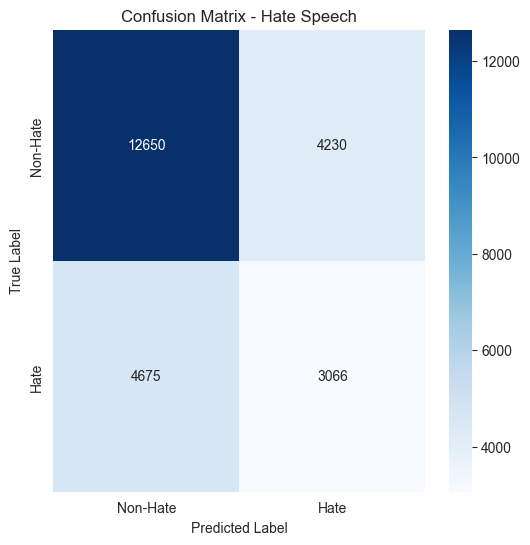

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred_hate_class = (y_pred_hate > 0.5).astype(int)
cm_hate = confusion_matrix(Y_test_hate_resample, y_pred_hate_class)

plt.figure(figsize=(6, 6))
sns.heatmap(cm_hate, annot=True, fmt="d", 
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'], 
            cmap='Blues')

plt.xlabel("Predicted Label") 
plt.ylabel("True Label")  
plt.title("Confusion Matrix - Hate Speech") 
plt.show()

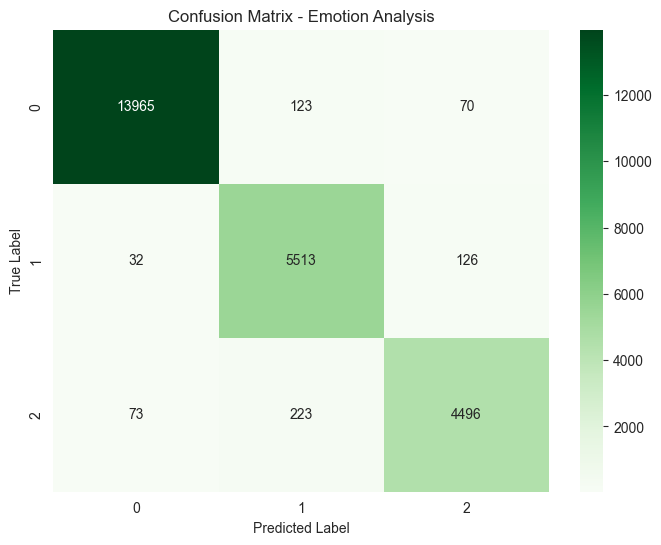

In [12]:
y_pred_emo_class = np.argmax(y_pred_emo, axis=1)

cm_emotion = confusion_matrix(Y_test_emo_resample, y_pred_emo_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_emotion, annot=True, fmt="d", 
            xticklabels=np.unique(Y_test_emo), 
            yticklabels=np.unique(Y_test_emo), 
            cmap='Greens')

plt.xlabel("Predicted Label") 
plt.ylabel("True Label")  
plt.title("Confusion Matrix - Emotion Analysis") 
plt.show()

## Learning Curve

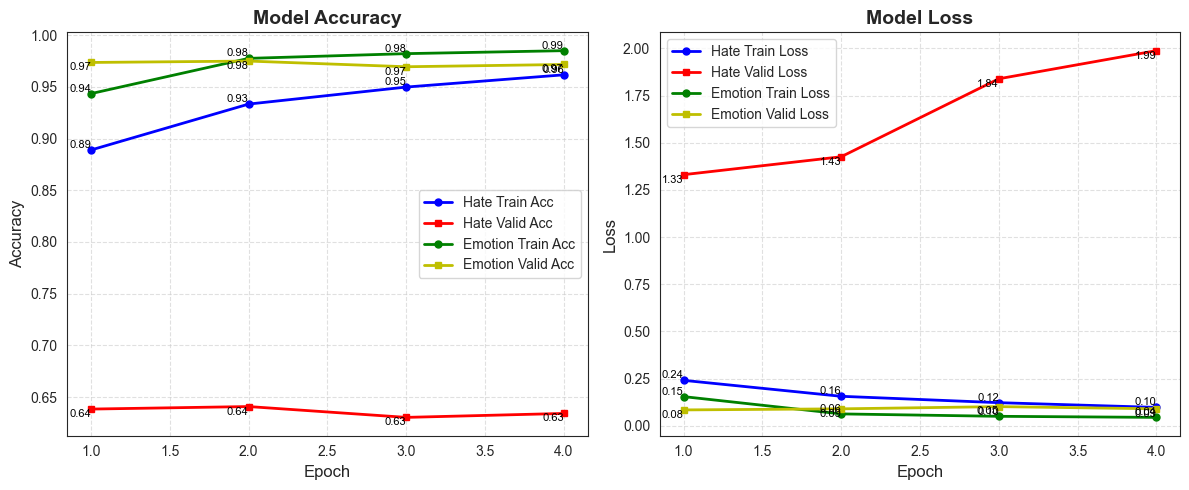

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_hate = history.history['hate_output_accuracy']
val_accuracy_hate = history.history['val_hate_output_accuracy']

accuracy_emotion = history.history['emotion_output_accuracy']
val_accuracy_emotion = history.history['val_emotion_output_accuracy']

loss_hate = history.history['hate_output_loss']
val_loss_hate = history.history['val_hate_output_loss']

loss_emotion = history.history['emotion_output_loss']
val_loss_emotion = history.history['val_emotion_output_loss']

epochs = range(1, len(accuracy_hate) + 1)

sns.set_style("white")  
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].plot(epochs, accuracy_hate, 'bo-', label='Hate Train Acc', linewidth=2, markersize=5)
axes[0].plot(epochs, val_accuracy_hate, 'rs-', label='Hate Valid Acc', linewidth=2, markersize=5)
axes[0].plot(epochs, accuracy_emotion, 'go-', label='Emotion Train Acc', linewidth=2, markersize=5)
axes[0].plot(epochs, val_accuracy_emotion, 'ys-', label='Emotion Valid Acc', linewidth=2, markersize=5)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy_hate)):
    axes[0].text(epochs[i], accuracy_hate[i], f"{accuracy_hate[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_accuracy_hate[i], f"{val_accuracy_hate[i]:.2f}", ha='right', va='top', fontsize=8, color='black')
    axes[0].text(epochs[i], accuracy_emotion[i], f"{accuracy_emotion[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_accuracy_emotion[i], f"{val_accuracy_emotion[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

axes[1].plot(epochs, loss_hate, 'bo-', label='Hate Train Loss', linewidth=2, markersize=5)
axes[1].plot(epochs, val_loss_hate, 'rs-', label='Hate Valid Loss', linewidth=2, markersize=5)
axes[1].plot(epochs, loss_emotion, 'go-', label='Emotion Train Loss', linewidth=2, markersize=5)
axes[1].plot(epochs, val_loss_emotion, 'ys-', label='Emotion Valid Loss', linewidth=2, markersize=5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss_hate)):
    axes[1].text(epochs[i], loss_hate[i], f"{loss_hate[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss_hate[i], f"{val_loss_hate[i]:.2f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], loss_emotion[i], f"{loss_emotion[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss_emotion[i], f"{val_loss_emotion[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()



## ROC-AUC Curve


📌 ROC AUC (Hate Speech): 0.6595


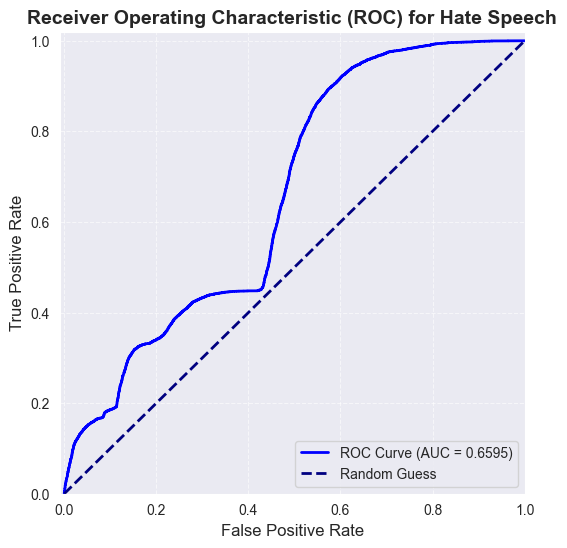

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test_hate_resample, y_pred_hate)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC (Hate Speech): {roc_auc:.4f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) for Hate Speech', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


## precision_recall_curve

770/770 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step

📌 Precision-Recall AUC: 0.3143


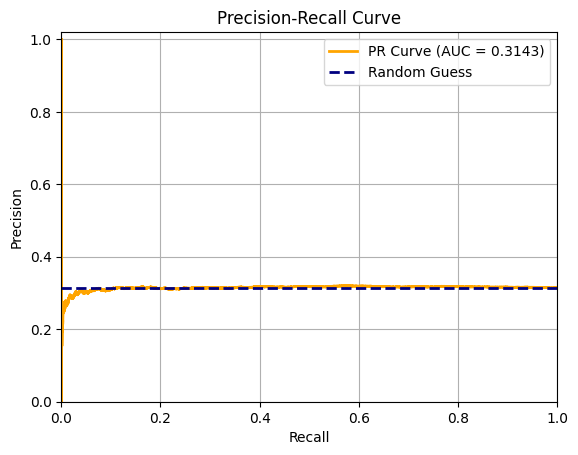

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model(r"Saved Model Hate/MTL_LSTM_okay/MTL_1_Model_imbalanceTestSet.h5")

y_pred_prob = model.predict({"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample})
y_pred_hate = y_pred_prob[0].flatten()

precision, recall, _ = precision_recall_curve(Y_test_hate_resample, y_pred_hate)
pr_auc = average_precision_score(Y_test_hate_resample, y_pred_hate)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test_hate_resample) / len(Y_test_hate_resample)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


# 2. Model (Undersampling Test Set)

## Word Embedding

In [3]:
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300 
MAX_VOCAB_SIZE_HATE = len(tokenizer_hate.word_index) + 1
MAX_VOCAB_SIZE_EMO = len(tokenizer_emo.word_index) + 1

hate_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="hate_input")
emo_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="emo_input")

# FastText
fasttext_path = "crawl-300d-2M-subword.bin" 
fasttext_vectors = FastText.load_fasttext_format(fasttext_path)

embedding_matrix_fastText = np.zeros((MAX_VOCAB_SIZE_HATE, EMBEDDING_DIM))
for word, i in tokenizer_hate.word_index.items():
    if i < MAX_VOCAB_SIZE_HATE:
        if word in fasttext_vectors.wv:
            embedding_matrix_fastText[i] = fasttext_vectors.wv[word]
        else:
            embedding_matrix_fastText[i] = np.random.normal(size=(EMBEDDING_DIM,))   

# Word2Vec
word2vec_path = "GoogleNews-vectors-negative300.bin"
word2vec_vectors = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

embedding_matrix_word2Vec = np.zeros((MAX_VOCAB_SIZE_EMO, EMBEDDING_DIM))
for word, i in tokenizer_emo.word_index.items():
    if i < MAX_VOCAB_SIZE_EMO:
        if word in word2vec_vectors:
            embedding_matrix_word2Vec[i] = word2vec_vectors[word]
        else:
            embedding_matrix_word2Vec[i] = np.random.normal(size=(EMBEDDING_DIM,))

hate_embedding = Embedding(
    input_dim=MAX_VOCAB_SIZE_HATE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix_fastText],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True
)(hate_input)

emo_embedding = Embedding(
    input_dim=MAX_VOCAB_SIZE_EMO,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix_word2Vec],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True
)(emo_input)

C:\Users\Asus\AppData\Local\Temp\ipykernel_27528\3902273608.py:11: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_vectors = FastText.load_fasttext_format(fasttext_path)
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Model

In [5]:
# hate speech Bi-LSTM
hate_lstm_1 = Bidirectional(LSTM(64, return_sequences=True))(hate_embedding)
hate_dropout_1 = Dropout(0.4)(hate_lstm_1)

hate_lstm_2 = Bidirectional(LSTM(96, return_sequences=True))(hate_dropout_1)
hate_dropout_2 = Dropout(0.4)(hate_lstm_2)

hate_lstm_3 = Bidirectional(LSTM(48, return_sequences=False))(hate_dropout_2)
hate_dropout_3 = Dropout(0.2)(hate_lstm_3)

# emotion Bi-LSTM
emo_lstm_1 = Bidirectional(LSTM(64, return_sequences=True))(emo_embedding)
emo_dropout_1 = Dropout(0.4)(emo_lstm_1)

emo_lstm_2 = Bidirectional(LSTM(96, return_sequences=True))(emo_dropout_1)
emo_dropout_2 = Dropout(0.4)(emo_lstm_2)

emo_lstm_3 = Bidirectional(LSTM(48, return_sequences=False))(emo_dropout_2)
emo_dropout_3 = Dropout(0.2)(emo_lstm_3)

# combined features
combined_features = concatenate([hate_dropout_3, emo_dropout_3])
shared_dense = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.071))(combined_features)

# output layer
hate_output = Dense(1, activation='sigmoid', name="hate_output")(shared_dense)
emotion_output = Dense(3, activation='softmax', name="emotion_output")(shared_dense)
model = Model(inputs=[hate_input, emo_input], outputs=[hate_output, emotion_output])

model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss={  "hate_output": "binary_crossentropy",  "emotion_output": "sparse_categorical_crossentropy" },
    metrics={ "hate_output": "accuracy", "emotion_output": "accuracy" }
)

early_stopping = EarlyStopping(monitor='val_hate_output_loss', mode='min',patience=3, restore_best_weights=True)

history = model.fit(
    x={  
        "hate_input": X_train_hate_resampled,
        "emo_input":X_train_emo_resampled},
    y={
        "hate_output": Y_train_hate_resampled,
        "emotion_output": Y_train_emo_resampled
    },
    epochs=10,
    batch_size=32,
    validation_data=(
        {
            "hate_input": X_test_hate_resample,
            "emo_input": X_test_emo_resample
        },
        {
            "hate_output": Y_test_hate_resample,
            "emotion_output": Y_test_emo_resample
        }
    ),
    callbacks=[early_stopping],
    verbose=1
)

# Save model-----------------------------------------------------------------------------------

model.save("MTL_Model_2_balanceTestSet.h5")
joblib.dump(history.history, "MTL_History_2_balanceTestSet.pkl")
print("Model saved successfully!")


Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 514s 444ms/step - emotion_output_accuracy: 0.7701 - emotion_output_loss: 0.4738 - hate_output_accuracy: 0.8287 - hate_output_loss: 0.3582 - loss: 1.1682 - val_emotion_output_accuracy: 0.9729 - val_emotion_output_loss: 0.0713 - val_hate_output_accuracy: 0.9167 - val_hate_output_loss: 0.1900 - val_loss: 0.2989
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 465s 412ms/step - emotion_output_accuracy: 0.9763 - emotion_output_loss: 0.0627 - hate_output_accuracy: 0.9357 - hate_output_loss: 0.1506 - loss: 0.2544 - val_emotion_output_accuracy: 0.9709 - val_emotion_output_loss: 0.0720 - val_hate_output_accuracy: 0.9174 - val_hate_output_loss: 0.1901 - val_loss: 0.2980
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 477s 423ms/step - emotion_output_accuracy: 0.9825 - emotion_output_loss: 0.0496 - hate_output_accuracy: 0.9562 - hate_output_loss: 0.1143 - loss: 0.1977 - val_emotion_output_accuracy: 0.9733 - val_emotion_output_loss: 0.0709 - val_hate_output_accuracy: 0

Model saved successfully!


## Evaluate

In [ ]:
# Validation Accurancy
results_Test = model.evaluate(
    {"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample}, 
    {"hate_output": Y_test_hate_resample, "emotion_output": Y_test_emo_resample}, 
    verbose=1,
    return_dict=True
)
print("\nEvaluation Results: (test)")
print("="*30)
print(f"Total Loss: {results_Test['loss']:.4f}")
print("-"*30)
print(f"Hate Loss: {results_Test['hate_output_loss']:.4f}")
print(f"Emotion Loss: {results_Test['emotion_output_loss']:.4f}")
print("-"*30)
print(f"Hate Accuracy: {results_Test['hate_output_accuracy']*100:.2f}%")
print(f"Emotion Accuracy: {results_Test['emotion_output_accuracy']*100:.2f}%")
print("="*30)


484/484 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - emotion_output_accuracy: 0.9775 - emotion_output_loss: 0.0688 - hate_output_accuracy: 0.9360 - hate_output_loss: 0.1435 - loss: 0.2499

Evaluation Results: (test)
Total Loss: 0.2989
------------------------------
Hate Loss: 0.1900
Emotion Loss: 0.0713
------------------------------
Hate Accuracy: 91.67%
Emotion Accuracy: 97.29%


In [7]:
# Train Accurancy
result_train = model.evaluate(
    {"hate_input": X_train_hate_resampled, "emo_input": X_train_emo_resampled}, 
    {"hate_output": Y_train_hate_resampled, "emotion_output": Y_train_emo_resampled}, 
    verbose=1,return_dict=True
)
print("\nEvaluation Results: (test)")
print("="*30)
print(f"Total Loss: {result_train['loss']:.4f}")
print("-"*30)
print(f"Hate Loss: {result_train['hate_output_loss']:.4f}")
print(f"Emotion Loss: {result_train['emotion_output_loss']:.4f}")
print("-"*30)
print(f"Hate Accuracy: {result_train['hate_output_accuracy']*100:.2f}%")
print(f"Emotion Accuracy: {result_train['emotion_output_accuracy']*100:.2f}%")
print("="*30)

1129/1129 ━━━━━━━━━━━━━━━━━━━━ 80s 71ms/step - emotion_output_accuracy: 0.9842 - emotion_output_loss: 0.0476 - hate_output_accuracy: 0.9541 - hate_output_loss: 0.1168 - loss: 0.2020

Evaluation Results: (test)
Total Loss: 0.2502
------------------------------
Hate Loss: 0.1592
Emotion Loss: 0.0534
------------------------------
Hate Accuracy: 94.13%
Emotion Accuracy: 98.06%


In [8]:
y_pred = model.predict({"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample})

y_pred_hate = y_pred[0]  
y_pred_emo = y_pred[1]  

y_pred_hate_class = (y_pred_hate > 0.5).astype(int)
y_pred_emo_class = np.argmax(y_pred_emo, axis=1)

print(f"\n-------------------------------😈 Hate 😈-------------------------------")

f1_weighted = f1_score(Y_test_hate_resample, y_pred_hate_class, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test_hate_resample, y_pred_hate_class, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test_hate_resample, y_pred_hate_class, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test_hate_resample, y_pred_hate_class, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test_hate_resample, y_pred_hate_class, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr_hate, tpr_hate, _ = roc_curve(Y_test_hate_resample, y_pred_hate)
roc_auc_hate = auc(fpr_hate, tpr_hate)
print(f"\n📌Test ROC AUC: {roc_auc_hate:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test_hate_resample, y_pred_hate_class))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test_hate_resample, y_pred_hate_class))

print(f"\n-------------------------------😈 Emotion 😈-------------------------------")

f1_weighted = f1_score(Y_test_emo_resample, y_pred_emo_class, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test_emo_resample, y_pred_emo_class, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test_emo_resample, y_pred_emo_class, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

Y_test_emo_bin = label_binarize(Y_test_emo_resample, classes=np.unique(Y_test_emo_resample))

n_classes = Y_test_emo_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_emo_bin[:, i], y_pred_emo[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Print ROC AUC for each class
for i in range(n_classes):
    print(f"📌Test ROC AUC for class {i}: {roc_auc[i]:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test_emo_resample, y_pred_emo_class))

print("Confusion Matrix:")
print(confusion_matrix(Y_test_emo_resample, y_pred_emo_class))


484/484 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step

-------------------------------😈 Hate 😈-------------------------------

📌 Weighted F1 Score: 0.9167
📌 Micro F1 Score: 0.9167
📌 Macro F1 Score: 0.9167

📌 Precision: 0.9066
📌 Recall: 0.9292

📌Test ROC AUC: 0.9785

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      7740
           1       0.91      0.93      0.92      7740

    accuracy                           0.92     15480
   macro avg       0.92      0.92      0.92     15480
weighted avg       0.92      0.92      0.92     15480


📌 Confusion Matrix:
[[6999  741]
 [ 548 7192]]

-------------------------------😈 Emotion 😈-------------------------------

📌 Weighted F1 Score: 0.9729
📌 Micro F1 Score: 0.9729
📌 Macro F1 Score: 0.9729
📌Test ROC AUC for class 0: 0.9985
📌Test ROC AUC for class 1: 0.9977
📌Test ROC AUC for class 2: 0.9982

📌 Classification Report:
              precision    recall  f1-score   support

       

##  Confusion Matrix

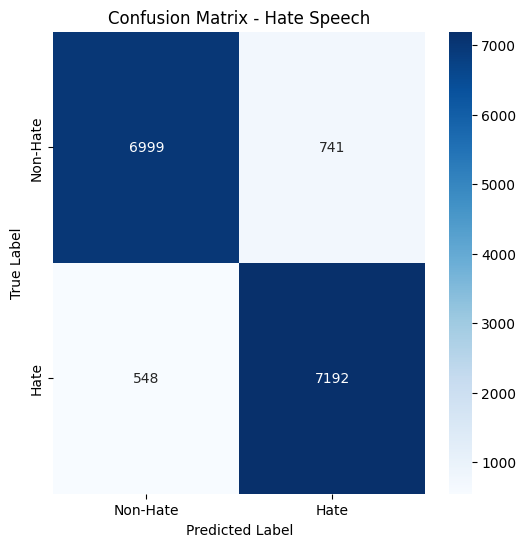

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred_hate_class = (y_pred_hate > 0.5).astype(int)

cm_hate = confusion_matrix(Y_test_hate_resample, y_pred_hate_class)

plt.figure(figsize=(6, 6))
sns.heatmap(cm_hate, annot=True, fmt="d", 
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'], 
            cmap='Blues')

plt.xlabel("Predicted Label") 
plt.ylabel("True Label")  
plt.title("Confusion Matrix - Hate Speech") 
plt.show()

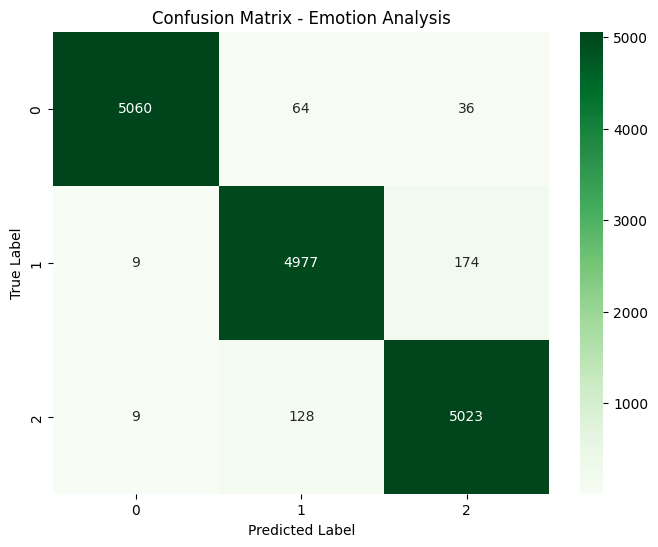

In [10]:
y_pred_emo_class = np.argmax(y_pred_emo, axis=1)

cm_emotion = confusion_matrix(Y_test_emo_resample, y_pred_emo_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_emotion, annot=True, fmt="d", 
            xticklabels=np.unique(Y_test_emo), 
            yticklabels=np.unique(Y_test_emo), 
            cmap='Greens')

plt.xlabel("Predicted Label") 
plt.ylabel("True Label")  
plt.title("Confusion Matrix - Emotion Analysis") 
plt.show()

## Learning Curve

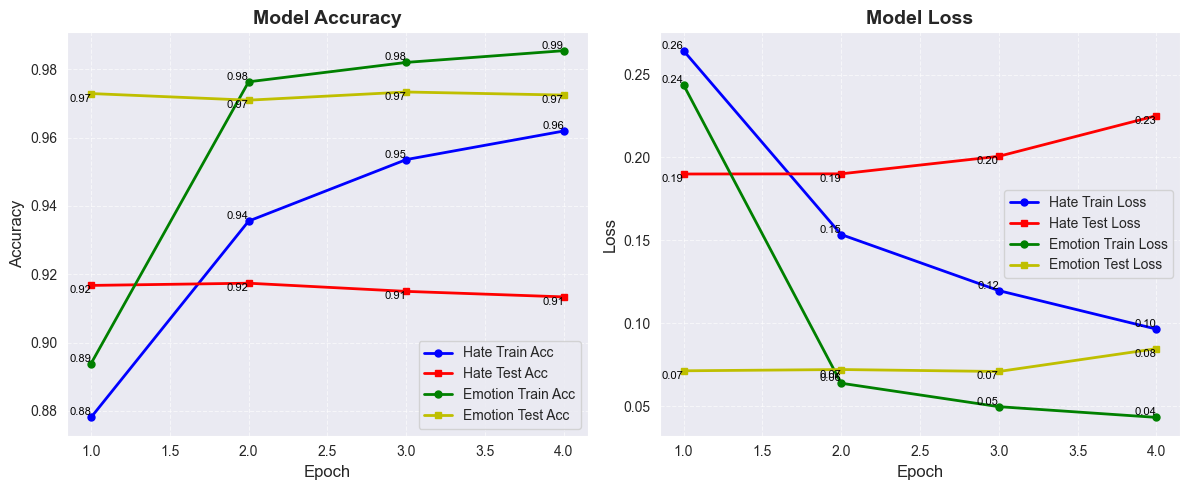

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_hate = history.history['hate_output_accuracy']
val_accuracy_hate = history.history['val_hate_output_accuracy']

accuracy_emotion = history.history['emotion_output_accuracy']
val_accuracy_emotion = history.history['val_emotion_output_accuracy']

loss_hate = history.history['hate_output_loss']
val_loss_hate = history.history['val_hate_output_loss']

loss_emotion = history.history['emotion_output_loss']
val_loss_emotion = history.history['val_emotion_output_loss']

epochs = range(1, len(accuracy_hate) + 1)

sns.set_style("darkgrid")  
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].plot(epochs, accuracy_hate, 'bo-', label='Hate Train Acc', linewidth=2, markersize=5)
axes[0].plot(epochs, val_accuracy_hate, 'rs-', label='Hate Test Acc', linewidth=2, markersize=5)
axes[0].plot(epochs, accuracy_emotion, 'go-', label='Emotion Train Acc', linewidth=2, markersize=5)
axes[0].plot(epochs, val_accuracy_emotion, 'ys-', label='Emotion Test Acc', linewidth=2, markersize=5)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy_hate)):
    axes[0].text(epochs[i], accuracy_hate[i], f"{accuracy_hate[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_accuracy_hate[i], f"{val_accuracy_hate[i]:.2f}", ha='right', va='top', fontsize=8, color='black')
    axes[0].text(epochs[i], accuracy_emotion[i], f"{accuracy_emotion[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_accuracy_emotion[i], f"{val_accuracy_emotion[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

axes[1].plot(epochs, loss_hate, 'bo-', label='Hate Train Loss', linewidth=2, markersize=5)
axes[1].plot(epochs, val_loss_hate, 'rs-', label='Hate Test Loss', linewidth=2, markersize=5)
axes[1].plot(epochs, loss_emotion, 'go-', label='Emotion Train Loss', linewidth=2, markersize=5)
axes[1].plot(epochs, val_loss_emotion, 'ys-', label='Emotion Test Loss', linewidth=2, markersize=5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss_hate)):
    axes[1].text(epochs[i], loss_hate[i], f"{loss_hate[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss_hate[i], f"{val_loss_hate[i]:.2f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], loss_emotion[i], f"{loss_emotion[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss_emotion[i], f"{val_loss_emotion[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()


## ROC-AUC Curve


📌 ROC AUC (Hate Speech): 0.9785


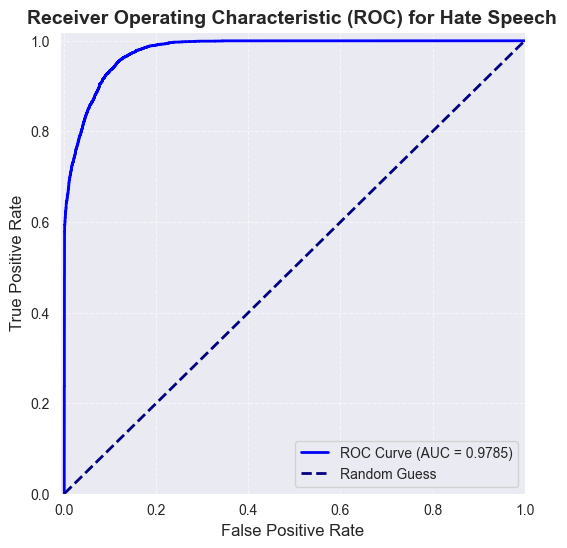

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test_hate_resample, y_pred_hate)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC (Hate Speech): {roc_auc:.4f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) for Hate Speech', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


## precision_recall_curve

770/770 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step

📌 Precision-Recall AUC: 0.3148


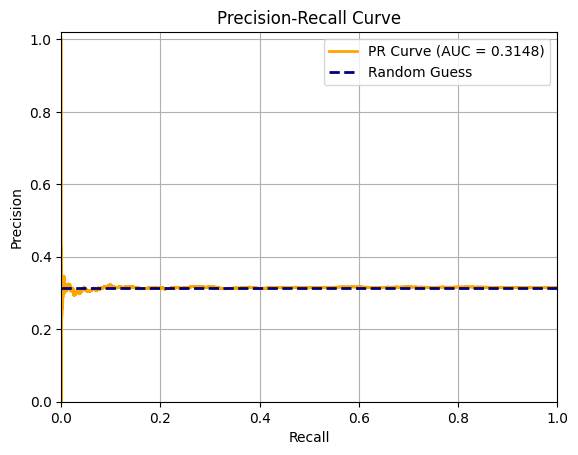

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

model = load_model(r"Saved Model Hate/MTL_LSTM_okay/MTL_2_Model_balanceTestSet.h5")

y_pred_prob = model.predict({"hate_input": X_test_hate_resample, "emo_input": X_test_emo_resample})
y_pred_hate = y_pred_prob[0].flatten() 

precision, recall, _ = precision_recall_curve(Y_test_hate_resample, y_pred_hate)
pr_auc = average_precision_score(Y_test_hate_resample, y_pred_hate)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test_hate_resample) / len(Y_test_hate_resample)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
